<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/InterpretationHD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the second dataset

In [0]:
#@title
import numpy as np
import torch 
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

!pip install flashtorch
from flashtorch.saliency import Backprop

!pip install shap 
import shap

!pip install pytorch-gradcam
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/cam.py -P local_modules -nc
!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/utils/visualize.py -P local_modules -nc
import sys
sys.path.append('local_modules')
from PIL import Image
from local_modules.visualize import visualize
import local_modules.cam as smooth

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/Hshapley13.py -P local_modules -nc
import local_modules.Hshapley13 as HS

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/utils.py -P local_modules -nc
import local_modules.utils as utils

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/interpret11.py -P local_modules -nc
import local_modules.interpret11 as intp

torch.manual_seed(0)
dtype = torch.float

FIGSIZE = (5,4)

import torch.nn as nn
import torch.nn.functional as F
class HD_Net(nn.Module):
    def __init__(self):
        super(HD_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride=5)
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv1 = nn.Conv2d(6, 10, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 16, 4)
        self.pool2 = nn.MaxPool2d(5)
        self.fc1 = nn.Linear(16 * 9 * 11, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = self.pool0(x)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, self.num_flat_features(x))  # 16*9*11
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = HD_Net()
# Loading the trained dictionnary state

net.load_state_dict(torch.load('drive/My Drive/Interpretability/modelHD.pth')) 

data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/HD/data2/data.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

Batch_Size = 64
#transf_temp =  transforms.Compose( [ToTensor()])
#train_data_temp = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf_temp)
#dataloader_temp = DataLoader(train_data_temp, batch_size = Batch_Size, shuffle = True, num_workers = 0)
#MEAN, STD = utils.datasetMeanStd(dataloader_temp)
MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

transf = transforms.Compose( [ToTensor(), Normalize(mean=MEAN, std=STD)])

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = Batch_Size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)


ImF = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/dataHD", transform = transf)
batch_Size = 3
exloader = DataLoader(ImF, batch_size = batch_Size, shuffle = False, num_workers = 0)

exIter = iter(exloader)
images, labels = next(exIter)

# For guided backprop
backprop = Backprop(net)

# For SHAP
X,Y = next(train_loader)
bg_choice = None # Default: entire training set, "average", "white", "black" 
# Median would result in white 
background = X
if (bg_choice == "black"): 
  background = -torch.ones(X.shape)
elif (bg_choice == "white"): 
  background = torch.ones(X.shape)
elif (bg_choice == "average"): 
  avg = torch.mean(X, dim = 0)
  display_image(avg, 0)
e = shap.GradientExplainer(net, background)

# For GradCAM
gradcam_conv = GradCAM(net, net.conv2)
gradcam_pp_conv = GradCAMpp(net, net.conv2)
gradcam_pool = GradCAM(net, net.pool2)
gradcam_pp_pool = GradCAMpp(net, net.pool2)

# For SmoothCAM
target_layer = net.conv2
wrapped_G = smooth.GradCAM(net, target_layer)
wrapped_P = smooth.GradCAMpp(net, target_layer)
wrapped_S = smooth.SmoothGradCAMpp(net, target_layer, n_samples=25, stdev_spread=0.15)
wrapped = [wrapped_G, wrapped_P, wrapped_S]

# For Hierarchical 
white_bg = torch.ones(images.shape[1:])
h = HS.HierarchicalShap(net, background = white_bg)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/cam.py’ already there; not retrieving.

File ‘local_modules/visualize.py’ already there; not retrieving.

File ‘local_modules/Hshapley13.py’ already there; not retrieving.

File ‘local_modules/utils.py’ already there; not retrieving.

File ‘local_modules/interpret11.py’ already there; not retrieving.




# EXAMPLE 0

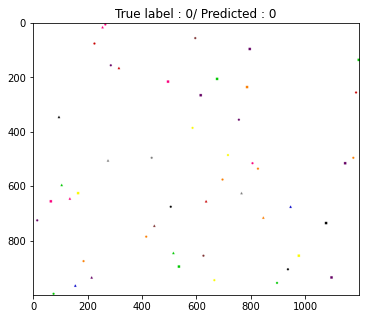

In [0]:
image0 = images[0]
label0 = labels[0]

input0 = image0.view(-1, 3, 1000, 1200) # This shape is necessary for the network 
output0 = net(input0)
_, predicted0 = torch.max(output0.data, 1)

img0 = utils.input2image(image0, MEAN, STD)
utils.display_image(img0, label0.numpy(), int(predicted0))

### Guided backpropagation explanation

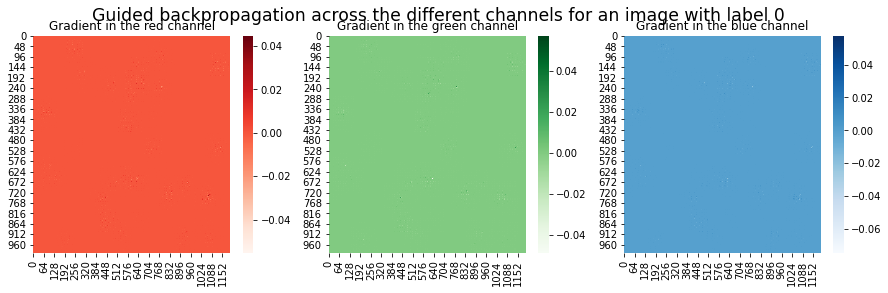

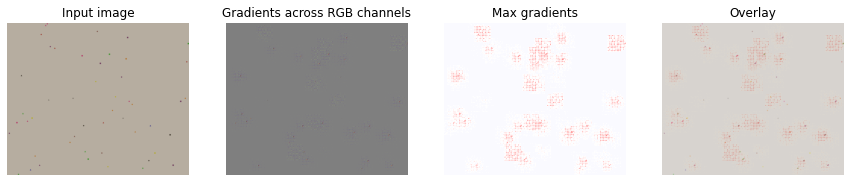

In [0]:
input0.requires_grad = True # Necessary to compute the gradient
gradients0 = backprop.calculate_gradients(input0, label0, guided = True).detach().numpy()
intp.display_gradients(gradients0, FIGSIZE).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");
backprop.visualize(input0, label0, guided=True, figsize = (3*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

### GradCAM explanation

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


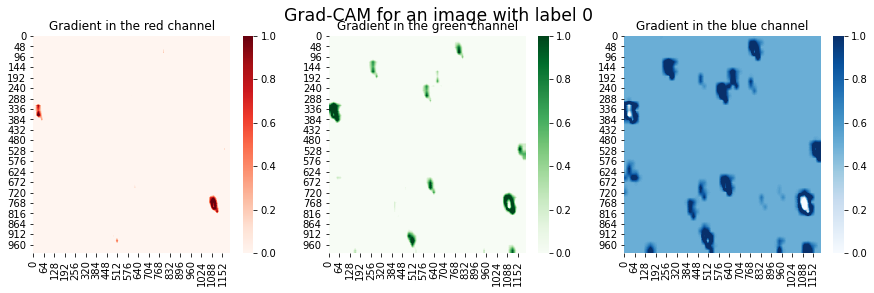

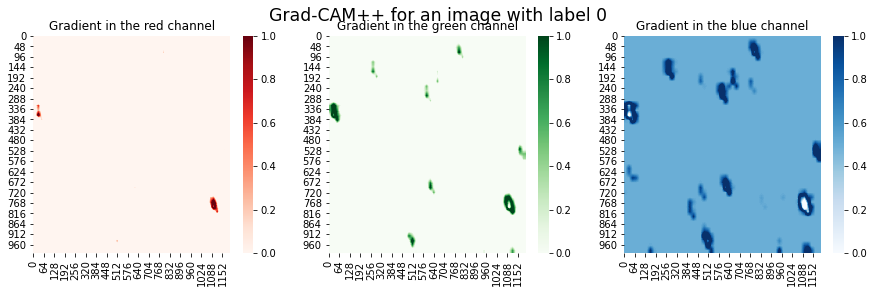

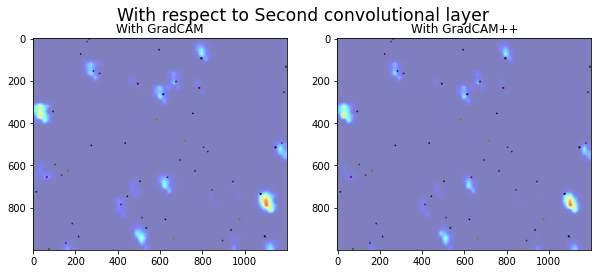

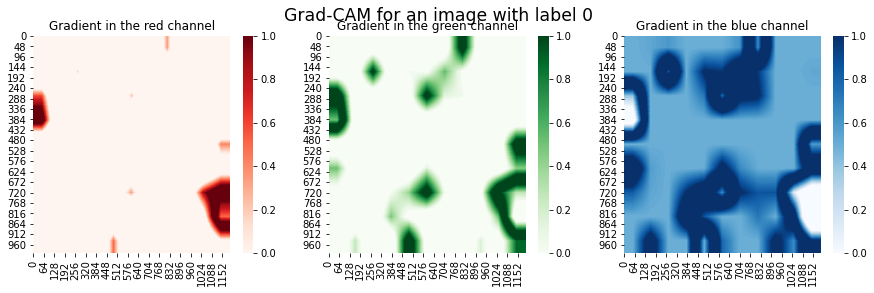

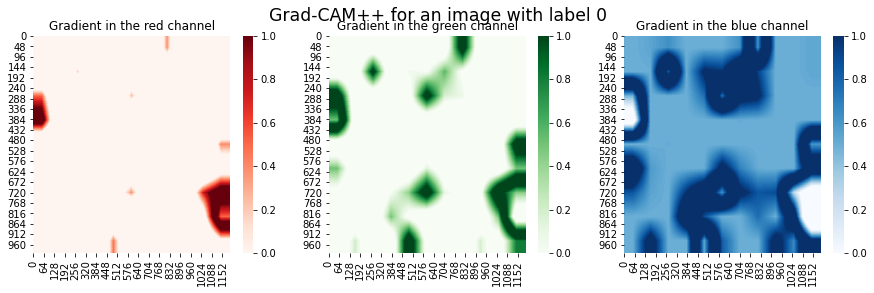

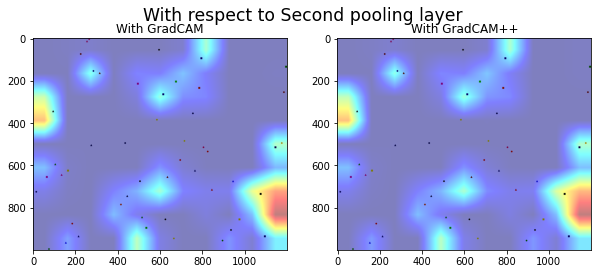

In [0]:
intp.gradcam_exp(gradcam_conv, gradcam_pp_conv, input0, img0,  "Second convolutional layer", FIGSIZE)
intp.gradcam_exp(gradcam_pool, gradcam_pp_pool, input0, img0,  "Second pooling layer", FIGSIZE)

### SmoothCAM explanation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 0	 probability 0.9999998807907104
predicted class ids 0	 probability 0.9999998807907104


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 1	 probability 0.999946117401123


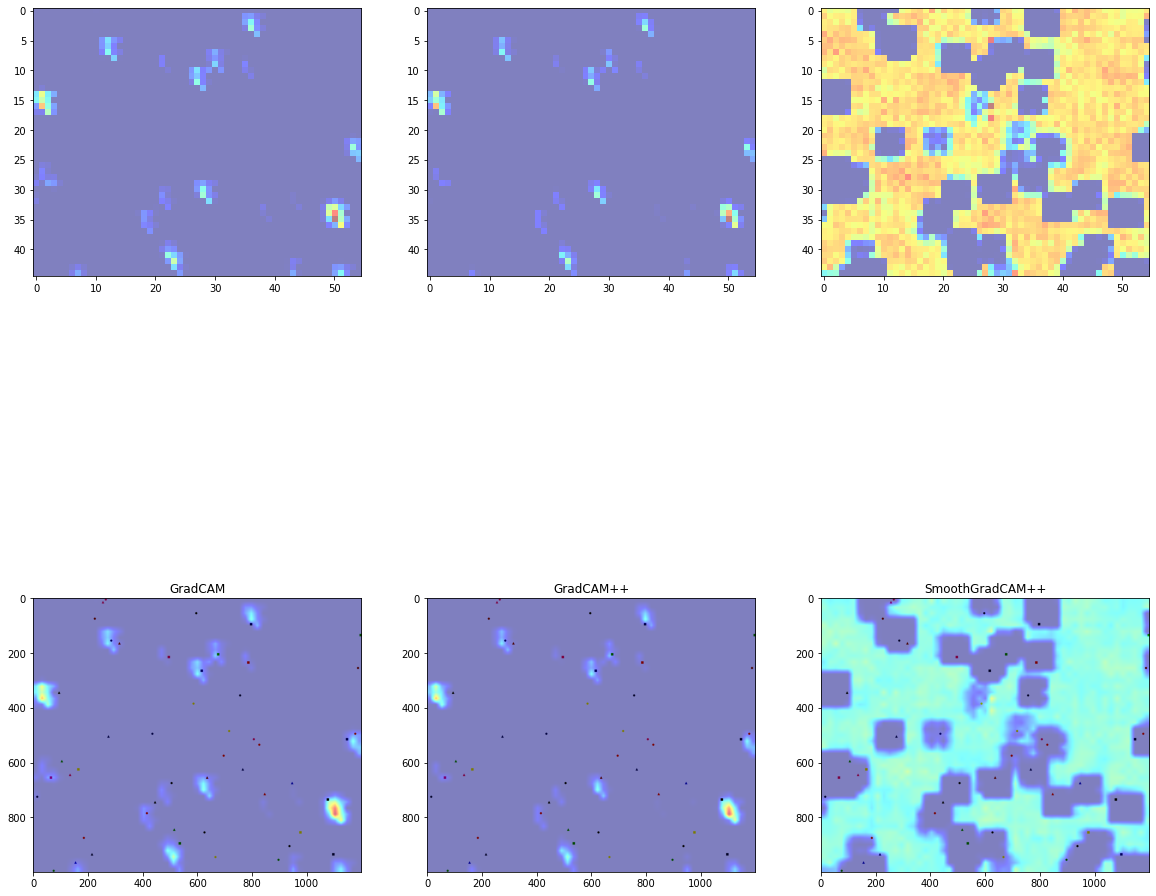

In [0]:
intp.smooth_exp(input0, image0, wrapped)

### Shapley explanation

In [0]:
#intp.shap_exp(e, input0.detach(), img0)

### Hierarchical Shapley explanation

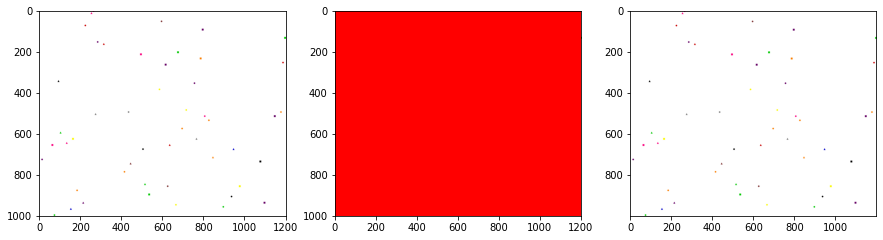

In [0]:
#h.shapMap(image0, label0, shapTol = [5,5.5,6,6.5,7])
h.shapMap(image0, label0, shapTol = [6], keepItSimple = True)

# EXAMPLE 1

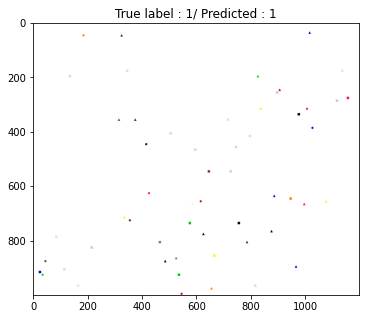

In [0]:
image1 = images[1]
label1 = labels[1]

input1 = image1.view(-1, 3, 1000, 1200)
output1 = net(input1)
_, predicted1 = torch.max(output1.data, 1)

img1 = utils.input2image(image1, MEAN, STD)
utils.display_image(img1, label1.numpy(), int(predicted1))

### Backpropagation

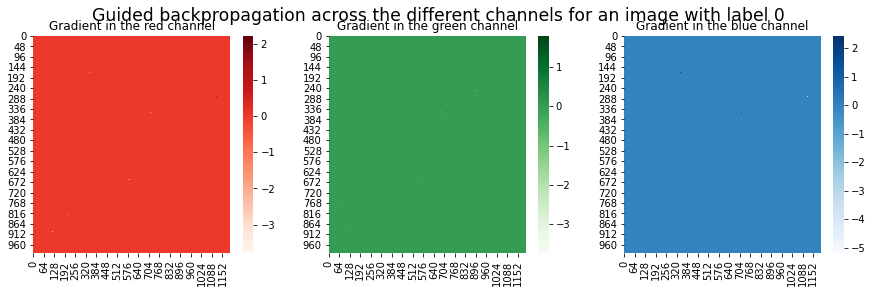

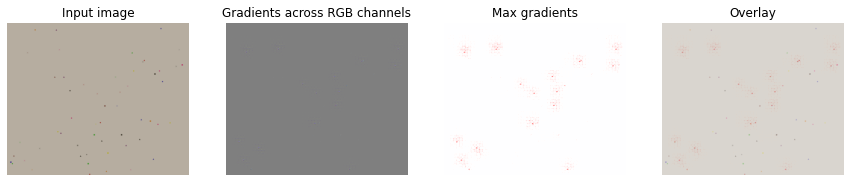

In [0]:
input1.requires_grad = True # Necessary to compute the gradient
gradients1 = backprop.calculate_gradients(input1, label1, guided = True).detach().numpy()
intp.display_gradients(gradients1, FIGSIZE).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");
backprop.visualize(input1, label1, guided=True, figsize = (3*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

### GradCAM

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


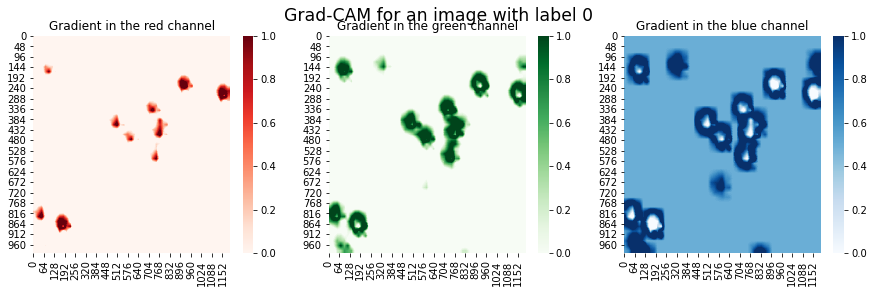

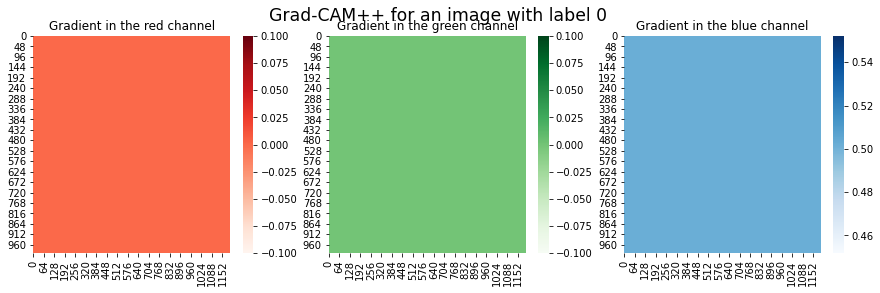

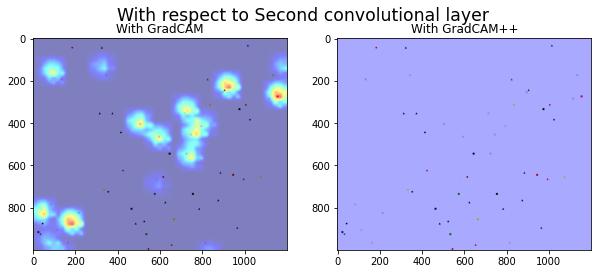

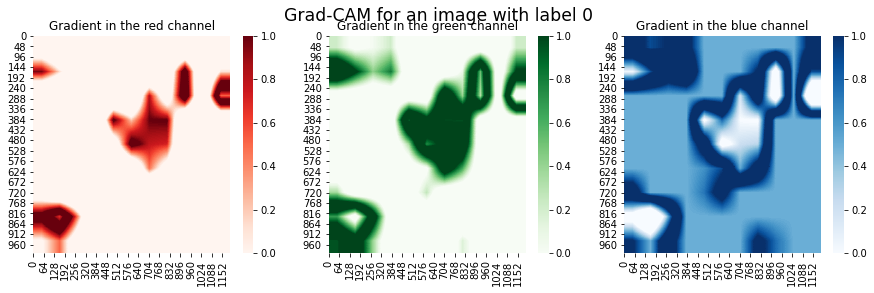

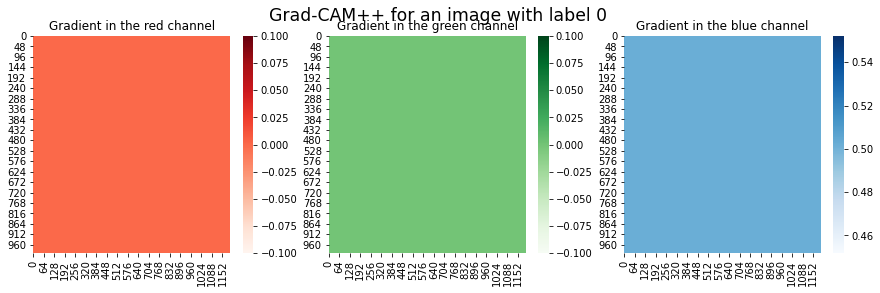

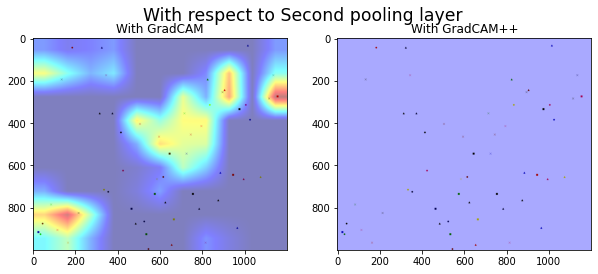

In [0]:
intp.gradcam_exp(gradcam_conv, gradcam_pp_conv, input1, img1,  "Second convolutional layer", FIGSIZE)
intp.gradcam_exp(gradcam_pool, gradcam_pp_pool, input1, img1,  "Second pooling layer", FIGSIZE)

### SmoothCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 1	 probability 1.0
predicted class ids 1	 probability 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 1	 probability 1.0


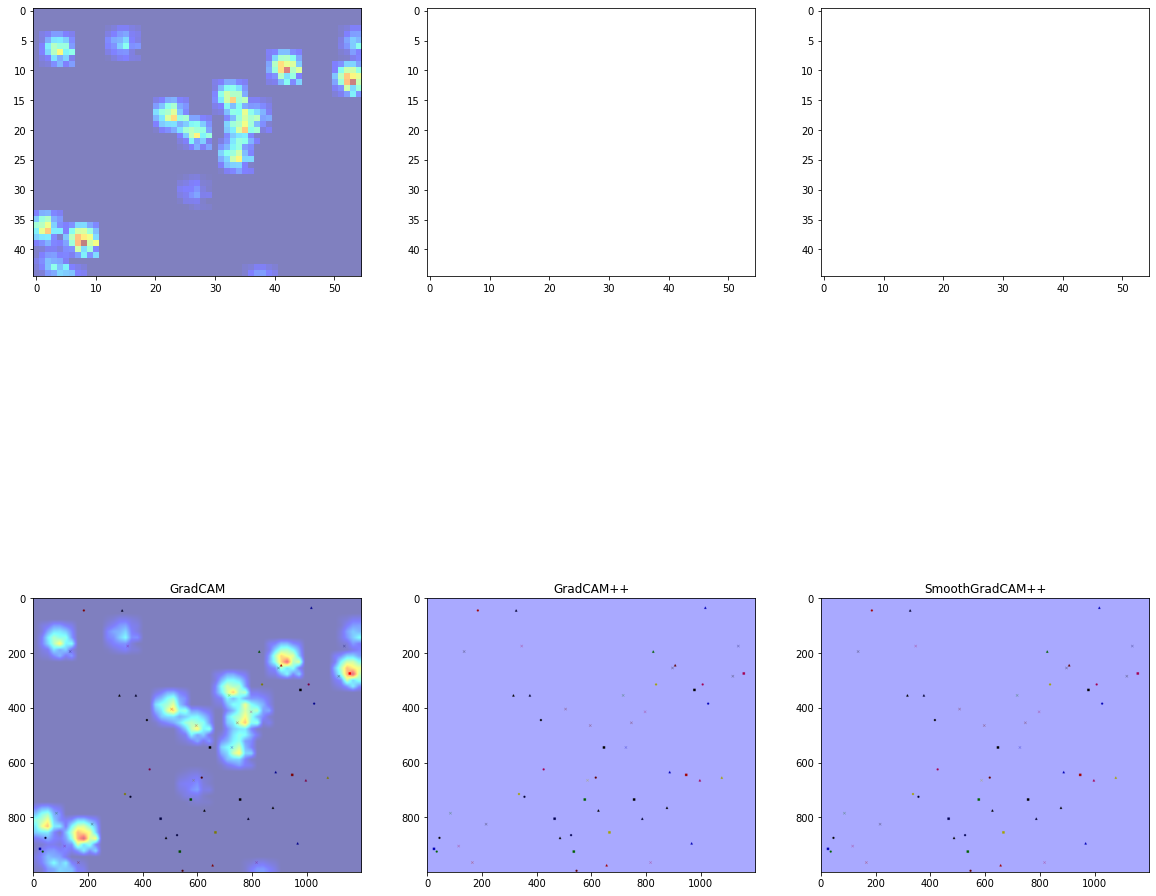

In [0]:
intp.smooth_exp(input1, image1, wrapped)

### Shapley explanation

In [0]:
#intp.shap_exp(e, input1.detach(), img1)

### Hierarchical Shapley

In [0]:
ht = HierarchicalShap(net, background = white_bg)

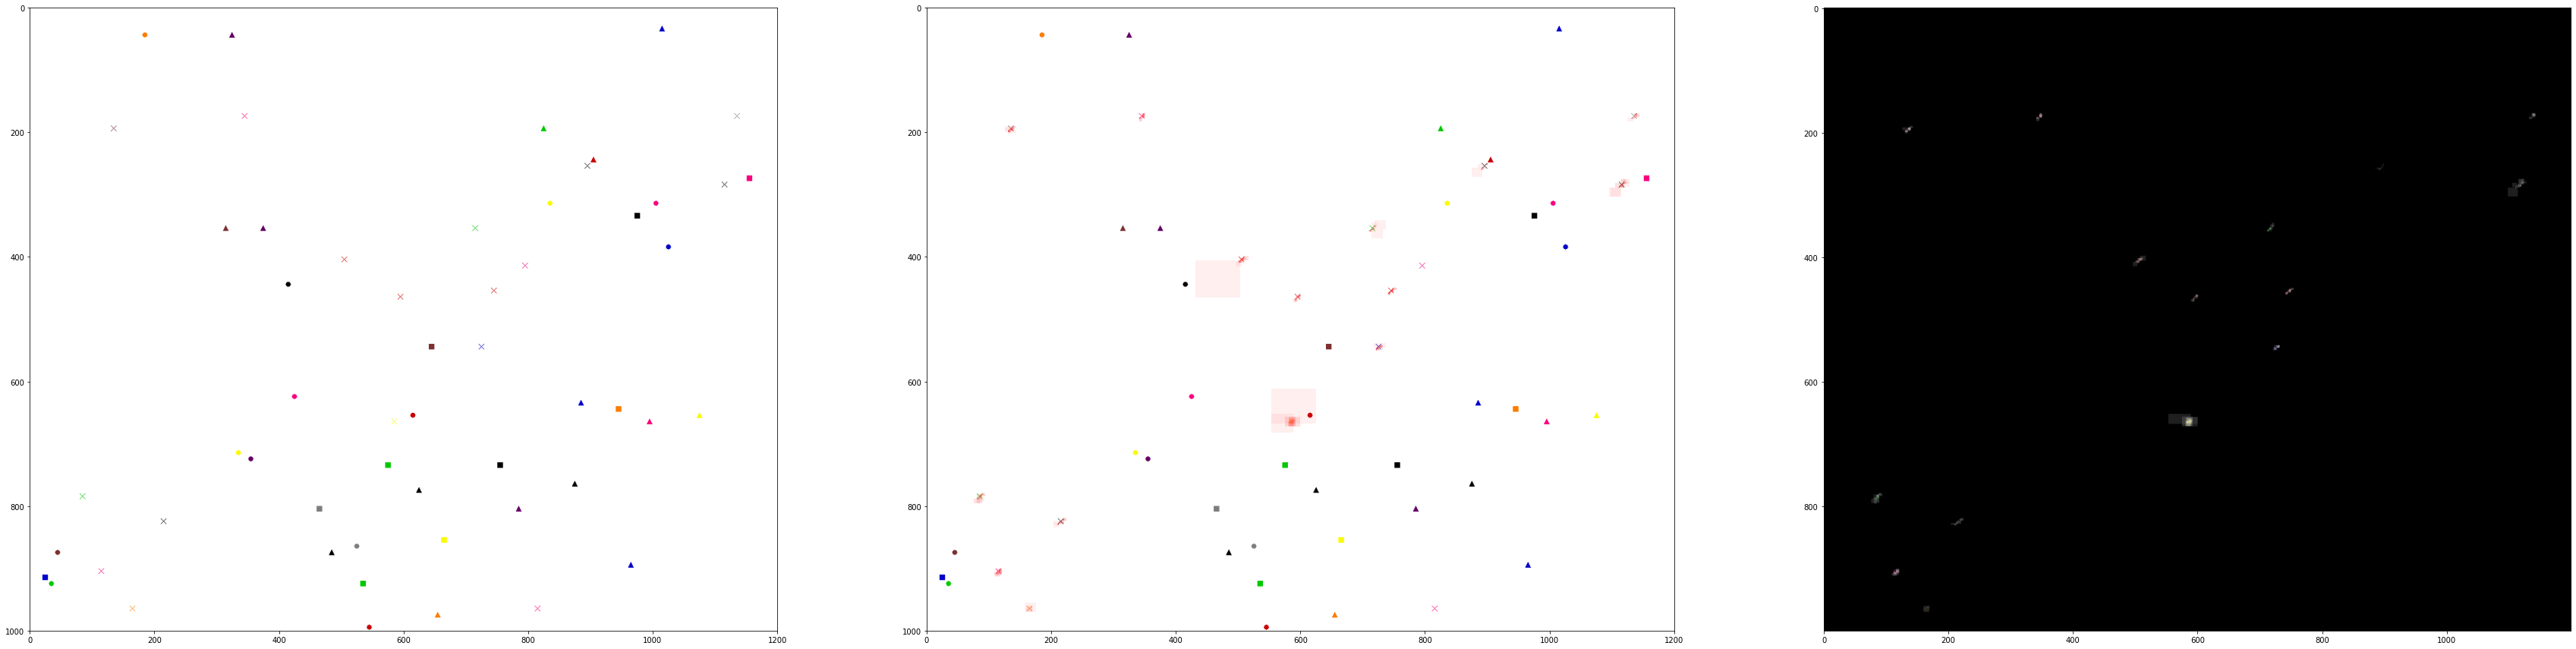

In [0]:
ht.shapMap(image1, label1, shapTol = [10], keepItSimple = False, debug=False)

In [0]:
class HierarchicalShap:
    """
    Explains the salient region of images for a given network.
    """

    def __init__(self, model, background, mean=np.array([0.5, 0.5, 0.5]), sd=np.array([0.5, 0.5, 0.5])):
        """
        Parameters
        ----------
        model: the model from which you wish to study the decision
        mean: the mean used for image normalization
        sd: the standard deviation used for normalization
        background_type: pre-defined background images. Can chose from {"white", "black"}
        background: if you want  to use a specified background
        """
        self.model = model
        self.mean = mean
        self.sd = sd

        self.background = background


    def display_cropped_images(self, images, score):
        mean = np.array([0.5, 0.5, 0.5])
        sd = np.array([0.5, 0.5, 0.5])
        fig, axs = plt.subplots(4, 4, figsize=(15, 15))
        for i in range(4):
            for j in range(4):
                sample_image = images[4 * i + j].numpy().transpose(1, 2, 0)
                im = sample_image * sd + mean
                axs[i, j].imshow(im)
                axs[i, j].set_title("#%d score:%f " % (4 * i + j, score[4 * i + j]))

    def construct_subsets(self, im, start=(0, 0), region_size=(None, None)):
        if (region_size[0] == None or region_size[1] == None):
            start = (0, 0)
            region_size = im.numpy().shape[1:3]

        middle = (start[0] + region_size[0] // 2, start[1] + region_size[1] // 2)
        end = (start[0] + region_size[0], start[1] + region_size[1])

        top_left = (start, (middle[0] - start[0], middle[1] - start[1]))
        top_right = ((start[0], middle[1]), (middle[0] - start[0], end[1] - middle[1]))
        bottom_left = ((middle[0], start[1]), (end[0] - middle[0], middle[1] - start[1]))
        bottom_right = (middle, (end[0] - middle[0], end[1] - middle[1]))
        regions = np.array([[top_left, top_right], [bottom_left, bottom_right]])

        subsets_size = [16]
        image_size = []
        for dim in im.shape:
            subsets_size.append(dim)
            image_size.append(dim)
        subsets = torch.zeros(subsets_size)

        bg = self.background
        # removing 0 features
        im1234 = bg.clone()
        im1234[:, start[0]:end[0], start[1]:end[1]] = im[:, start[0]:end[0], start[1]:end[1]]
        # removing 1 feature
        im234 = im1234.clone()
        im234[:, start[0]:middle[0], start[1]:middle[1]] = bg[:, start[0]:middle[0], start[1]:middle[1]]
        im134 = im1234.clone()
        im134[:, start[0]:middle[0], middle[1]:end[1]] = bg[:, start[0]:middle[0], middle[1]:end[1]]
        im124 = im1234.clone()
        im124[:, middle[0]:end[0], start[1]:middle[1]] = bg[:, middle[0]:end[0], start[1]:middle[1]]
        im123 = im1234.clone()
        im123[:, middle[0]:end[0], middle[1]:end[1]] = bg[:, middle[0]:end[0], middle[1]:end[1]]
        # removing 2 features
        im34 = im234.clone()
        im34[:, start[0]:middle[0], middle[1]:end[1]] = bg[:, start[0]:middle[0], middle[1]:end[1]]
        im24 = im234.clone()
        im24[:, middle[0]:end[0], start[1]:middle[1]] = bg[:, middle[0]:end[0], start[1]:middle[1]]
        im23 = im234.clone()
        im23[:, middle[0]:end[0], middle[1]:end[1]] = bg[:, middle[0]:end[0], middle[1]:end[1]]
        im14 = im134.clone()
        im14[:, middle[0]:end[0], start[1]:middle[1]] = bg[:, middle[0]:end[0], start[1]:middle[1]]
        im13 = im134.clone()
        im13[:, middle[0]:end[0], middle[1]:end[1]] = bg[:, middle[0]:end[0], middle[1]:end[1]]
        im12 = im123.clone()
        im12[:, middle[0]:end[0], start[1]:middle[1]] = bg[:, middle[0]:end[0], start[1]:middle[1]]
        # removing 3 features
        im4 = im34.clone()
        im4[:, middle[0]:end[0], start[1]:middle[1]] = bg[:, middle[0]:end[0], start[1]:middle[1]]
        im3 = im34.clone()
        im3[:, middle[0]:end[0], middle[1]:end[1]] = bg[:, middle[0]:end[0], middle[1]:end[1]]
        im2 = im24.clone()
        im2[:, middle[0]:end[0], middle[1]:end[1]] = bg[:, middle[0]:end[0], middle[1]:end[1]]
        im1 = im14.clone()
        im1[:, middle[0]:end[0], middle[1]:end[1]] = bg[:, middle[0]:end[0], middle[1]:end[1]]
        # removing 4
        im_ = bg.clone()

        subsets[0] = im1234
        subsets[1] = im234
        subsets[2] = im134
        subsets[3] = im124
        subsets[4] = im123
        subsets[5] = im34
        subsets[6] = im24
        subsets[7] = im23
        subsets[8] = im14
        subsets[9] = im13
        subsets[10] = im12
        subsets[11] = im4
        subsets[12] = im3
        subsets[13] = im2
        subsets[14] = im1
        subsets[15] = im_

        return subsets, regions

    def subsetScores(self, sub, label):
        outputs = self.model(sub)

        score = np.zeros(16)
        score[0] = outputs[0, label]
        score[1] = outputs[1, label]
        score[2] = outputs[2, label]
        score[3] = outputs[3, label]
        score[4] = outputs[4, label]
        score[5] = outputs[5, label]
        score[6] = outputs[6, label]
        score[7] = outputs[7, label]
        score[8] = outputs[8, label]
        score[9] = outputs[9, label]
        score[10] = outputs[10, label]
        score[11] = outputs[11, label]
        score[12] = outputs[12, label]
        score[13] = outputs[13, label]
        score[14] = outputs[14, label]
        score[15] = outputs[15, label]
        return score

    def constructShapMap(self, score):
        phi1 = (score[14] - score[15] + score[0] - score[1]) / 4 \
               + (score[8] - score[11] + score[9] - score[12] + score[10] - score[13]
                  + score[2] - score[5] + score[3] - score[6] + score[4] - score[7]) / 12
        # verified

        phi2 = (score[13] - score[15] + score[0] - score[2]) / 4 \
               + (score[6] - score[11] + score[7] - score[12] + score[10] - score[14]
                  + score[1] - score[5] + score[3] - score[8] + score[4] - score[9]) / 12
        # verified

        phi3 = (score[12] - score[15] + score[0] - score[3]) / 4 \
               + (score[5] - score[11] + score[9] - score[14] + score[7] - score[13]
                  + score[2] - score[8] + score[1] - score[6] + score[4] - score[10]) / 12
        # verified

        phi4 = (score[11] - score[15] + score[0] - score[4]) / 4 \
               + (score[8] - score[14] + score[5] - score[12] + score[6] - score[13]
                  + score[1] - score[7] + score[3] - score[10] + score[2] - score[9]) / 12
        # verified

        shap_map = np.array([[phi1, phi2], [phi3, phi4]])
        return shap_map

    def get_salient_regions(self, shap_map, shapTol, regions):
        srs = []
        for i in range(len(shap_map)):
            for j in range(len(shap_map)):
                if (shap_map[i, j] > shapTol):
                    srs.append(regions[i, j])
        return srs

    def display_salient(self, im, srs_coll):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(60, 40))
        sample_image = im.numpy().transpose(1, 2, 0)
        image = sample_image * self.sd + self.mean
        ax1.imshow(image)
        ax2.imshow(image)
        mask = np.zeros(image.shape)

        for srs in srs_coll:
            for sr in srs:
                start = sr[0]
                q_size = sr[1]

                xs = [start[1], start[1] + q_size[1], start[1] + q_size[1], start[1]]
                ys = [start[0], start[0], start[0] + q_size[0], start[0] + q_size[0]]
                ax2.fill(xs, ys, 'r', alpha=1 / len(srs_coll))
                mask[start[0]:start[0] + q_size[0], start[1]:start[1] + q_size[1]] += np.ones((q_size[0], q_size[1], 3))
        # Normalize the mask to the range (0,1)
        mask /= np.max(mask)
        # Set to 0 elements smaller than 1/10
        negligible = (mask < 0.1)
        mask[negligible] = 0

        ax1.set_xlim([0, im.shape[2]])
        ax1.set_ylim([im.shape[1], 0])
        ax2.set_xlim([0, im.shape[2]])
        ax2.set_ylim([im.shape[1], 0])
        ax3.imshow(image * mask)

    def do_all(self, im, label, strt, region_size, shapTol, debug=False):

        images_final, regions = self.construct_subsets(im, strt, region_size)
        score = self.subsetScores(images_final, label)
        sm = self.constructShapMap(score)
        if (debug):
            self.display_cropped_images(images_final, score)
            f = plt.figure()
            sns.heatmap(sm)
            f.suptitle("Shap values of each quadrant");

        srs = self.get_salient_regions(sm, shapTol, regions)

        return srs

    def shapMap(self, image, label, shapTol=[6], keepItSimple=False, debug=False):
        max_depth = 30
        ls = []
        delta = [image.shape[1] // 20, image.shape[2] // 24]
        xf = [image.shape[1], image.shape[2]]
        starts = [(0, 0), (0, delta[1]), (delta[0], 0), (delta[0], delta[1])]
        ends = [(xf[0], xf[1]), (xf[0], xf[1] - delta[1]), (xf[0] - delta[0], xf[1]),
                (xf[0] - delta[0], xf[1] - delta[1])]
        if (keepItSimple):
            starts = [(0, 0)]
            ends = [(xf[0], xf[1])]

        for tol in shapTol:
            try:
                for start in starts:
                    for end in ends:
                        size = (end[0] - start[0], end[1] - start[1])
                        srs = [(start, size)]
                        finished = []
                        k = 0
                        while (len(srs) > 0):
                            if (k > max_depth):
                                raise RuntimeError("Depth %d reached at tolereance %f" % (k, tol))
                            all_ = []
                            for sr in srs:
                                s = self.do_all(image, label, sr[0], sr[1], tol, debug)
                                if (s == []):
                                    finished.append(((sr[0]), (sr[1])))
                                else:
                                    all_ += s
                            srs = all_
                            k += 1
                        ls.append(finished)
            except RuntimeError as w:
                print(w, "Run ignored, consider increasing tolerance.")

        self.display_salient(image, ls)